In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from collections import Counter
from wordcloud import WordCloud
from typing import Dict, Tuple, Sequence, Final
from enum import Enum

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

from sklearn.cluster import KMeans

from src.services import VideoCategory

stop_eng = set(stopwords.words('english'))

# downloads for nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

## tags options for wordnet lemmatizer tag params
TAGS_DICT = {"j": wordnet.ADJ,
            "n": wordnet.NOUN,
            "v": wordnet.VERB,
            "r": wordnet.ADV
          }

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>


In [4]:
class WordText(Enum):
    TEXT = 'text'
    WORD = 'word'

In [5]:
youtube_data_keys = {'official', 'video', 'music', 'skiza', 'clip', 
                     'call', 'lyrics', '𝐅𝐎𝐑', '𝐁𝐎𝐎𝐊𝐈𝐍𝐆𝐒',  '𝐂𝐀𝐋𝐋', '𝐉𝐀𝐇𝐀𝐙𝐈', 'instagram', 'twitter', 'facebook', 'channel', 'subscribe', 'youtube', 'follow', 'like', 'yuh', '𝐓𝐀𝐀𝐑𝐀𝐁', '𝐌𝐎𝐃𝐄𝐑𝐍', 'yuh', 'you', 'officiel'}
                     
stop_eng.update(youtube_data_keys)

# lambdas functions: 

classify_views = lambda x: 'Above one million' if x > 1000000 else 'Below one million'
classify_likes = lambda x: 'Above 20k' if x > 20000 else 'Below 20k'
classify_comments = lambda x: 'Above 1k' if x > 1000 else 'Below 1k'

def get_wordnet_tag_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].lower()
  return TAGS_DICT.get(tag[0], 'n')

def lemmatize_word(token):
  wordnet_lemmatizer = WordNetLemmatizer()
  pos = get_wordnet_tag_pos(token)
  return wordnet_lemmatizer.lemmatize(token, pos = pos)

def process_text(data, method_type ='word'):

  '''
  This function process the text sentence by removing special characters; lemmatizing tokens and returning a word token or a sentence token

  input: 
    data: the list of text 
    method_type: specify to return a word or sentence
  '''
  
  tokenized_data = []
  for title in data:

    # remove links
    text = re.sub(r"http\S+", "", title)
    
    # remove special characters even emojis;
    title = re.sub("[^A-Za-z]+", " ", text)

    tokenize = nltk.word_tokenize(title.lower())

    filtered_token = list(filter(
        lambda word: not (
            word in stop_eng or len(word) <= 3), tokenize))

    lemmatized_tokens = [lemmatize_word(token) for token in filtered_token]

    if method_type == WordText.TEXT.value:
      tokenized_data.append(' '.join(lemmatized_tokens))
    if method_type == WordText.WORD.value:
      tokenized_data.extend(lemmatized_tokens)
      
  return tokenized_data
  
 # word cloud visualization
def word_cloud_visualization(data):
    title_counter = Counter(tokenize_words(data))

    def black_color_func(word, font_size, position, orientation, random_state=1, **kwargs):
        return ("hsl(0, 100%,1%)")

    wordcloud = WordCloud(background_color="white",
                          width=3000, height=2000, max_words=500).generate_from_frequencies(title_counter)

    wordcloud.recolor(color_func=black_color_func)
    plt.figure(figsize=[15, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

In [7]:
# category = VideoCategory().get_categories()
# print(category)
from dotenv import load_dotenv

load_dotenv()


False

In [201]:
youtube_data = pd.read_csv('data/youtube_search.csv').drop(columns=['Unnamed: 0'])
# youtube_data['category_id'] = youtube_data['category_id'].apply(
#     lambda x: category[x])

ValueError: Authorized user info was not in the expected format, missing fields client_id, refresh_token, client_secret.

In [193]:
youtube_data = pd.read_csv(
    '../data/youtube_search.csv').drop(columns=['Unnamed: 0'])


FileNotFoundError: [Errno 2] No such file or directory: '../data/youtube_search.csv'

In [163]:
youtube_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             110 non-null    object
 1   category_id    110 non-null    object
 2   channel_title  110 non-null    object
 3   channel_id     110 non-null    object
 4   description    108 non-null    object
 5   published_at   110 non-null    object
 6   title          110 non-null    object
 7   views_count    110 non-null    int64 
 8   comment_count  110 non-null    int64 
 9   likes_count    110 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 8.7+ KB


In [164]:
youtube_data.describe()

,views_count,comment_count,likes_count
count,1.100000e+02,110.000000,110.000000
mean,5.515678e+05,1213.654545,15889.636364
std,1.320979e+06,2601.526099,55552.532870
min,2.130000e+02,0.000000,3.000000
25%,1.130300e+04,39.500000,134.500000
50%,5.515950e+04,144.500000,840.000000
75%,3.673410e+05,1003.000000,8693.750000
max,7.666258e+06,19025.000000,398368.000000


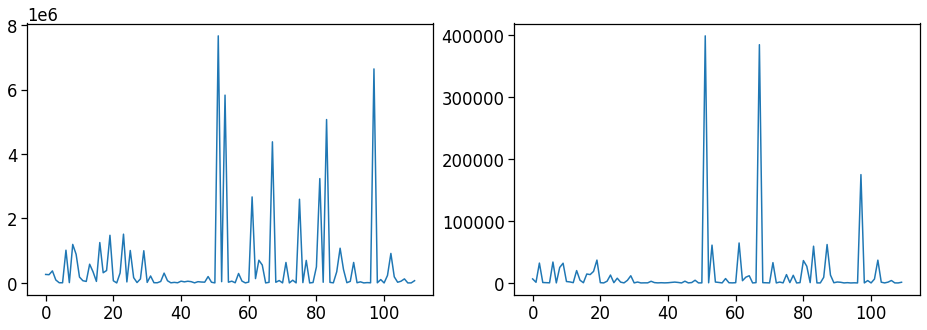

In [165]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
ax[0].plot(youtube_data.views_count)
ax[1].plot(youtube_data.likes_count)

In [166]:
views_binary = youtube_data['views_count'].apply(classify_views)
likes_binary = youtube_data['likes_count'].apply(classify_likes)
comments_binary = youtube_data['comment_count'].apply(classify_comments)
classified = pd.concat([youtube_data.loc[:, ["channel_title", "category_id"]], likes_binary, views_binary, comments_binary], axis=1)
classified.head()

,channel_title,category_id,likes_count,views_count,comment_count
0,Jason Billam Travel,Travel & Events,Below 20k,Below one million,Above 1k
1,Scenic Relaxation,People & Blogs,Below 20k,Below one million,Below 1k
2,Kurt Caz,Travel & Events,Above 20k,Below one million,Above 1k
3,Dennis THE NATIONAL,Travel & Events,Below 20k,Below one million,Below 1k
4,Uncle mo from Kenya,People & Blogs,Below 20k,Below one million,Below 1k


Text(0.5, 0.98, 'Youtube Trending Analysis')

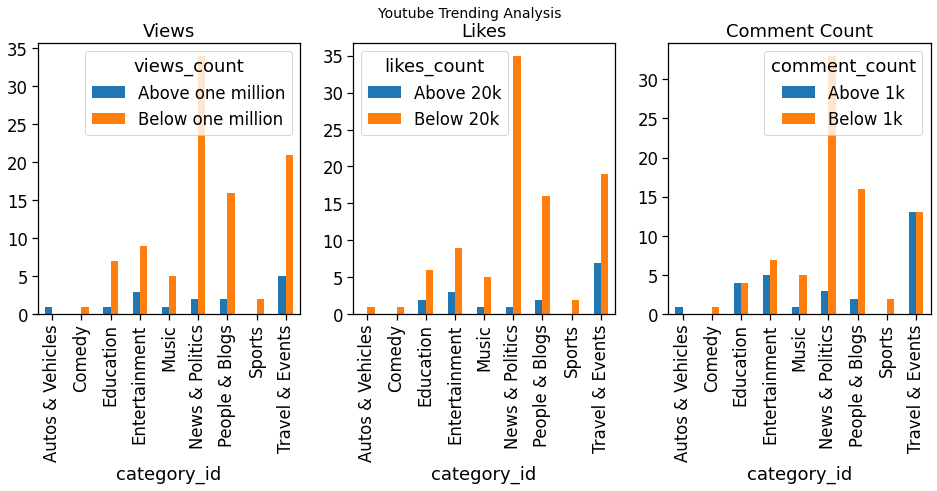

In [167]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

classified.groupby(["category_id", "views_count"]).size(
  ).unstack().plot.bar(title="Views", ax=ax[0])
classified.groupby(["category_id", "likes_count"]).size(
  ).unstack().plot.bar(title="Likes", ax=ax[1])
classified.groupby(["category_id", "comment_count"]).size( 
  ).unstack().plot.bar(title="Comment Count", ax=ax[2])
fig.suptitle("Youtube Trending Analysis", fontsize=14)

<AxesSubplot:title={'center':'Category Summary Analysis'}, xlabel='category_id'>

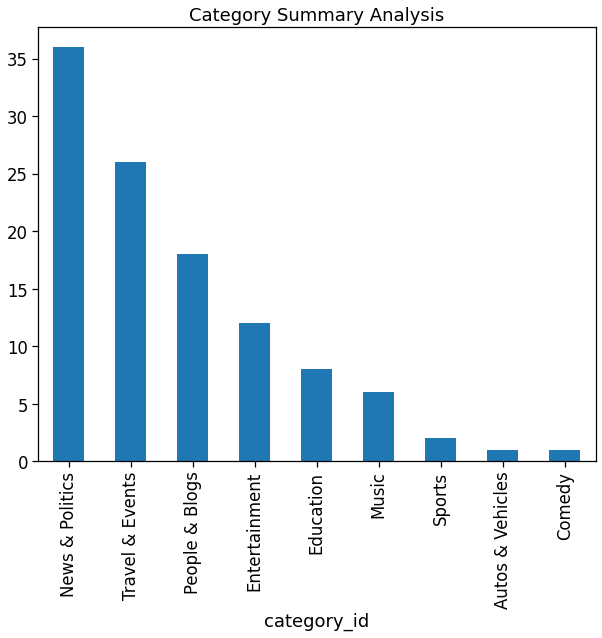

In [168]:
youtube_data.groupby("category_id").size().sort_values(ascending=False).plot.bar(title = 'Category Summary Analysis')

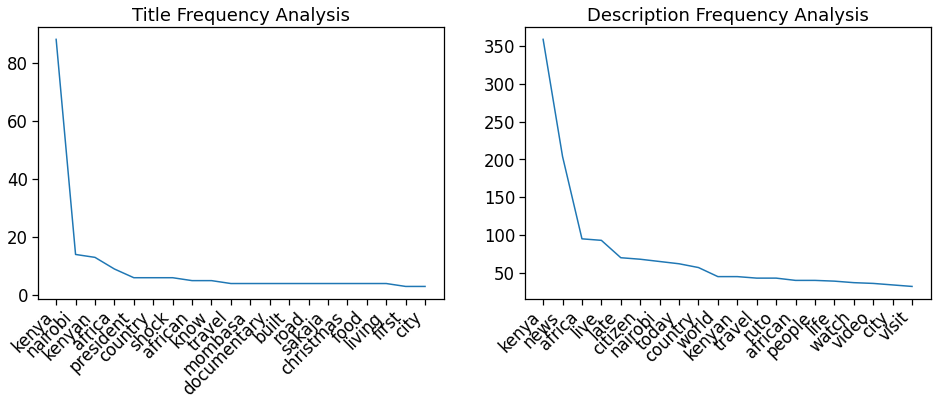

In [171]:
# Visualizing the most common trends using dictionary word counters for text representation

# Unigram Model

## Unigram model makes a dictionary of 1 element and counts it occurences. The vocabulary becomes the features which are used to make the vectors for each sentences. 

title_counter = Counter(process_text(youtube_data.title))
title_counter_sorted = dict(sorted(title_counter.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].plot(list(title_counter_sorted.keys())[
         :20], list(title_counter_sorted.values())[:20])
ax[0].set_title('Title Frequency Analysis')
plt.setp(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right');

title_counter = Counter(process_text(youtube_data.description.dropna()))
title_counter_sorted = dict(
    sorted(title_counter.items(), key=lambda x: x[1], reverse=True))

ax[1].plot(list(title_counter_sorted.keys())[
    :20], list(title_counter_sorted.values())[:20])
ax[1].set_title('Description Frequency Analysis')
plt.setp(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right');

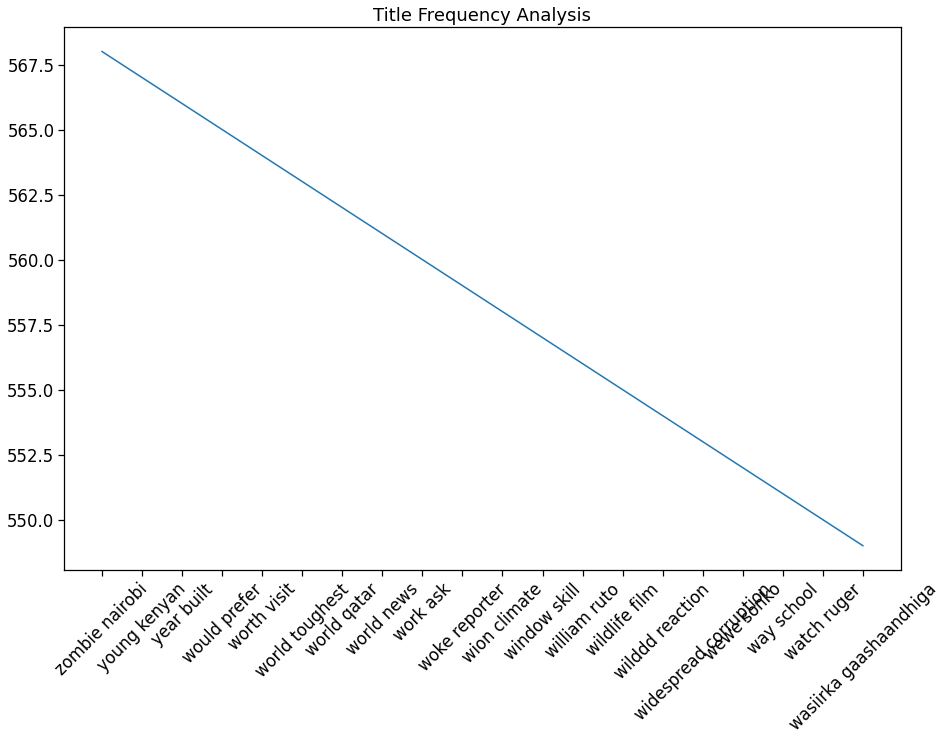

In [175]:
# N-gram model: 

# This model uses the occurence of two words and uses them as the new features for representing the document. The document are represented binarily. If the feature is present in the document, it is assigned 1 else 0. 

cv = CountVectorizer(ngram_range=[2, 2], stop_words=stop_eng)
bow = cv.fit_transform(process_text(
    youtube_data.title, method_type='text')).toarray()
    
title_counter_sorted = dict(
    sorted(cv.vocabulary_.items(), key=lambda x: x[1], reverse=True))
    
title_counter_sorted = dict(
    sorted(cv.vocabulary_.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(15, 10))
plt.plot(list(title_counter_sorted.keys())[
         :20], list(title_counter_sorted.values())[:20]);
plt.xticks(rotation=45);
plt.title('Title Frequency Analysis');

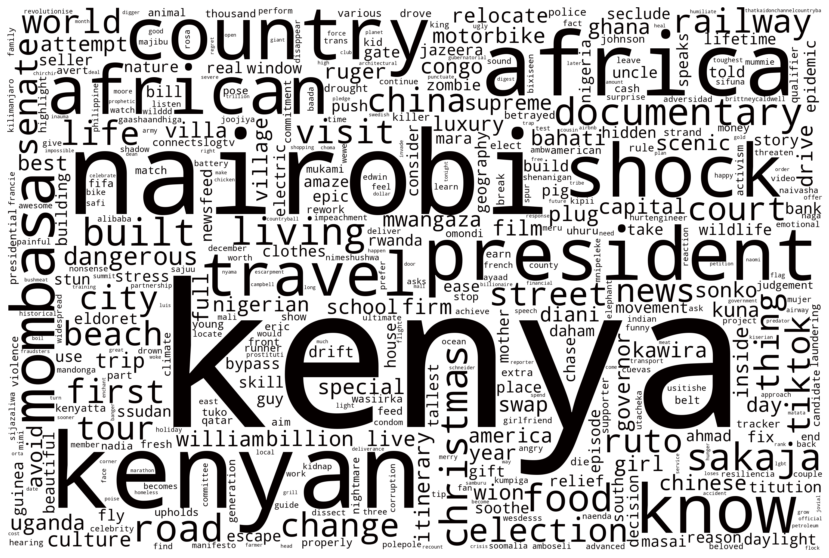

In [176]:
word_cloud_visualization(youtube_data.title)

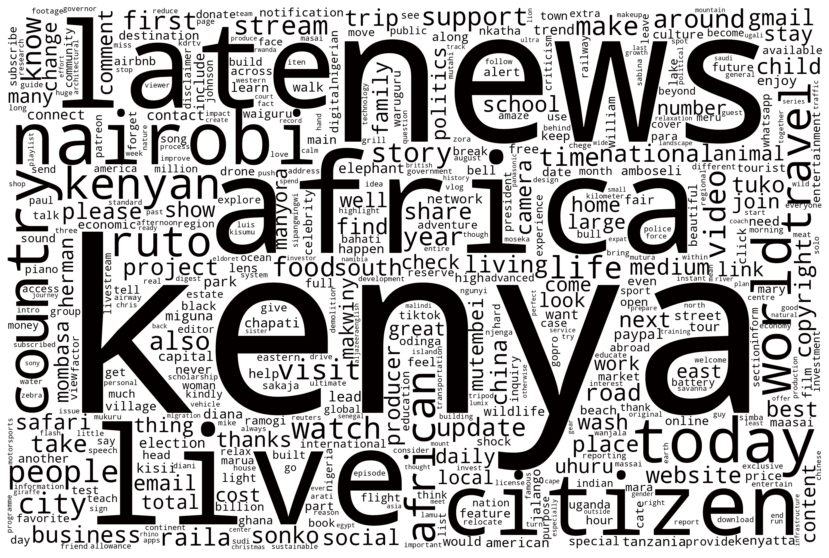

In [177]:
word_cloud_visualization(youtube_data.description.dropna())

In [178]:
# TF-IDF (Term Frequency and Inverse Document Frequency)

# Term-Frequency: the number of occurence (Term T) appearing in the document divided by the all documents. 
# Inverse Document Frequency: Numbers of documents in a corpus divided by the number of documents with the term T. If we have a word that comes in all documents then the resultant output of the log is zero. 
process_youtube_title = process_text(youtube_data.title, 'text')
tfidf = TfidfVectorizer()
tfidf_youtube_matrix = tfidf.fit_transform(process_youtube_title).toarray()
tfidf_youtube_matrix.shape

(110, 456)

In [179]:
dist = 1 - cosine_similarity(tfidf_youtube_matrix)

## Clustering and Topic Analysis for different videos

In [184]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_youtube_matrix)
clusters = km.labels_.tolist()

In [185]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

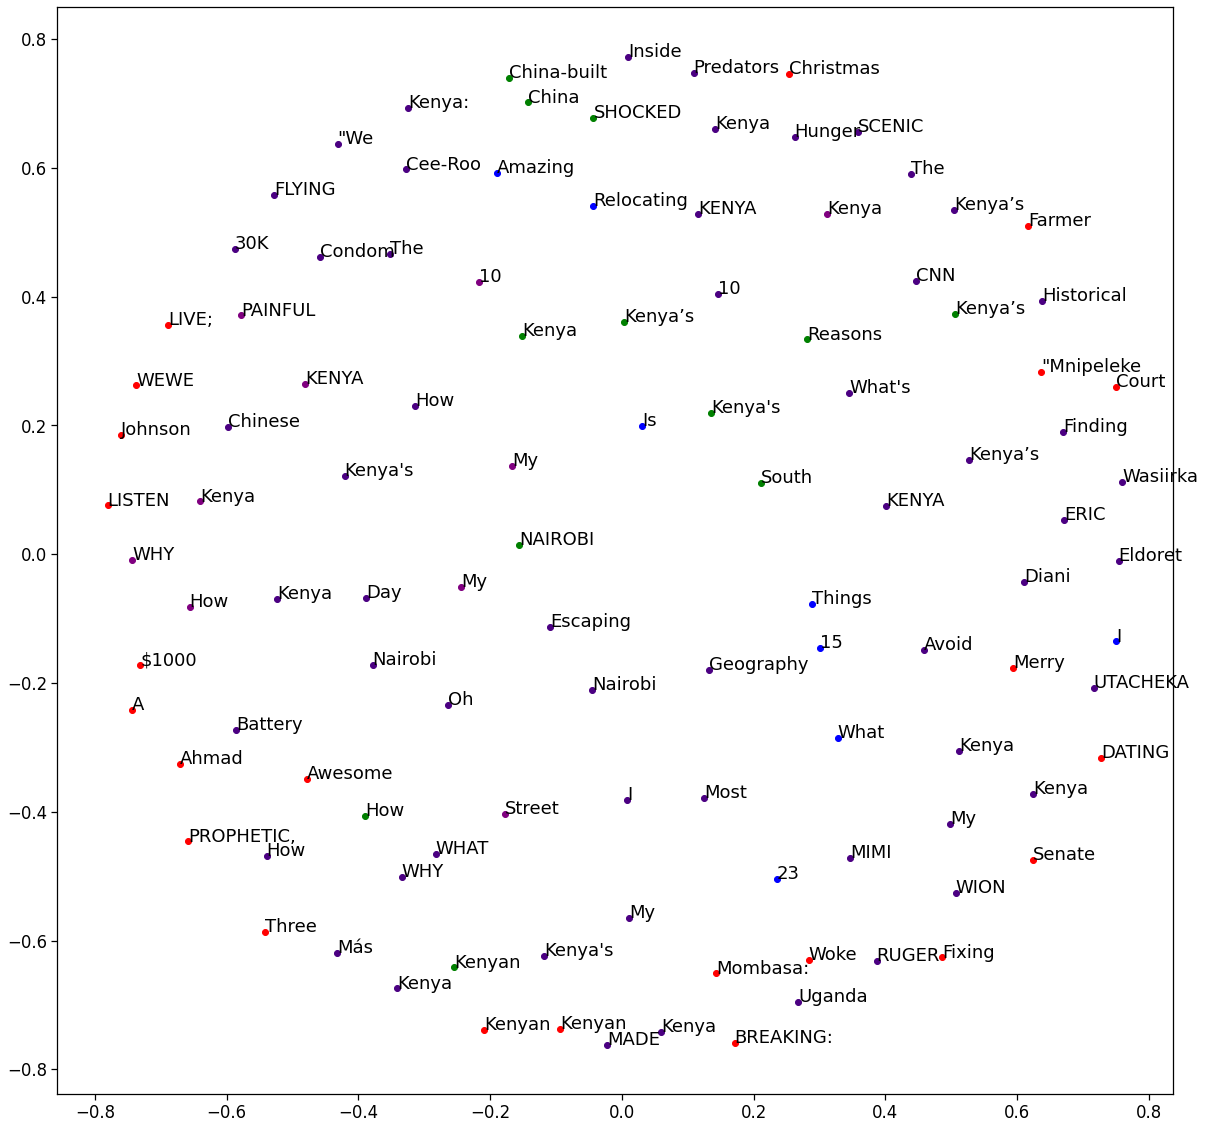

In [186]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters,
                  title=youtube_data.title))

#group by cluster
groups = df.groupby('label')
color_map = {
  0:'red', 
  1: 'g',
  2: 'blue', 
  3: 'indigo',
  4: 'purple',
}
plt.figure(figsize=(20, 20))
for name, group in groups:
  
  for _, d in group.iterrows():
    x, y, lab, title = d
    plt.scatter(x, y, c=color_map[lab])
    plt.text(x, y, title.split(' ')[0])
plt.savefig('search_clusters.png')    

In [187]:
for name, group in groups:
  l = []
  
  for _, d in group.iterrows():
    x, y, lab, title = d
    l.append(title)

  with open(f'group_{lab}.txt', 'w', encoding='utf-8') as fp:
    for t in l:
      fp.write(f'{t} \n \n')

## References: 

1. https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f
2. http://brandonrose.org/clustering